In [1]:
from typing import Callable
import functools
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import numpy as np
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
plt.style.use('ipynb')

In [2]:
class RectangularSignal:
    """Create a signal defined on a rectangular region from a function of theta and phi."""

    def __init__(self, grid_values: jax.Array, res_theta: int, res_phi: int):
        self.grid_values = grid_values
        self.res_theta = res_theta
        self.res_phi = res_phi
        assert self.grid_values.shape == (*self.grid_values.shape[:-2], res_theta, res_phi)
    
    def from_function(f: Callable[[jax.Array, jax.Array], jax.Array], res_theta: int, res_phi: int, wrap_theta: bool = False):
        """Create a signal from a function of theta and phi."""
        if wrap_theta:
            def f_wrapped(theta, phi):
                f_val = f(theta, phi)
                fd_val = f(2 * jnp.pi - theta, phi)
                return jnp.where(theta < jnp.pi, f_val, fd_val)
            func = f_wrapped
        else:
            func = f
        thetas, phis = jnp.meshgrid(RectangularSignal.thetas(res_theta), RectangularSignal.phis(res_phi), indexing="ij")
        fn_vmap = jax.vmap(jax.vmap(func))
        grid_values = fn_vmap(thetas, phis)

        return RectangularSignal(grid_values, res_theta, res_phi)
    
    @staticmethod
    def thetas(res_theta: int):
        """Returns the theta values of the grid."""
        return jnp.linspace(0, 2 * jnp.pi, res_theta)
    
    @staticmethod
    def phis(res_phi: int):
        """Returns the phi values of the grid."""
        return jnp.linspace(0, 2 * jnp.pi, res_phi)
    
    def grid_values(self) -> jax.Array:
        """Computes the values of the signal on the grid."""
        # Use the double fourier trick.  
        if self.wrap_theta:
            def f_wrapped(theta, phi):
                f_val = self.f(theta, phi)
                fd_val = self.f(2 * jnp.pi - theta, phi)
                return jnp.where(theta < jnp.pi, f_val, fd_val)
            func = f_wrapped
        else:
            func = self.f

        thetas, phis = jnp.meshgrid(self.thetas(), self.phis(), indexing="ij")
        fn_vmap = jax.vmap(jax.vmap(func))
        return fn_vmap(thetas, phis)
    
    def integrate(self) -> jax.Array:
        """Computes the integral of the signal over the sphere."""
        grid_values = self.grid_values

        # Integrate over theta axis first, with the trapezoidal rule.
        # Ideally we would use the symmetry around theta = pi to reduce the number of points to integrate over,
        # but I don't think it's worth the effort for now.
        thetas = RectangularSignal.thetas(self.res_theta)
        dtheta = thetas[1] - thetas[0]
        theta_weights = jnp.concatenate([jnp.array([0.5]), jnp.ones(len(thetas) - 2), jnp.array([0.5])])
        integral = jnp.sum(grid_values * theta_weights[:, None], axis=0) * dtheta
        assert integral.shape == (self.res_phi,)

        # Integrate over phi axis next, with the trapezoidal rule.
        phis = RectangularSignal.phis(self.res_phi)
        dphi = phis[1] - phis[0]
        phi_weights = jnp.concatenate([jnp.array([0.5]), jnp.ones(len(phis) - 2), jnp.array([0.5])])
        integral = jnp.sum(integral * phi_weights, axis=0) * dphi
        assert integral.shape == ()
        return integral
    
    def __mul__(self, other):
        """Pointwise multiplication of two signals."""
        assert isinstance(other, RectangularSignal)
        assert self.res_theta == other.res_theta
        assert self.res_phi == other.res_phi
        return RectangularSignal(self.grid_values * other.grid_values, self.res_theta, self.res_phi)

In [3]:
def from_lm_index(lm_index: int) -> tuple:
    l = jnp.floor(jnp.sqrt(lm_index)).astype(jnp.int32)
    m = lm_index - l * (l + 1)
    return l, m


def to_lm_index(l: int, m: int) -> int:
    return l * (l + 1) + m


def sh_phi(l: int, m: int, phi: float) -> float:
    r"""Phi dependence of spherical harmonics.

    Args:
        l: l value
        phi: phi value

    Returns:
        Array of shape ``(2 * l + 1,)``
    """
    assert phi.ndim == 0
    phi = phi[..., None]  # [..., 1]
    ms = jnp.arange(1, l + 1)  # [1, 2, 3, ..., l]
    cos = jnp.cos(ms * phi)  # [..., m]

    ms = jnp.arange(l, 0, -1)  # [l, l-1, l-2, ..., 1]
    sin = jnp.sin(ms * phi)  # [..., m]

    return jnp.concatenate(
        [
            jnp.sqrt(2) * sin,
            jnp.ones_like(phi),
            jnp.sqrt(2) * cos,
        ],
        axis=-1,
    )[l + m]


def sh_theta(l: int, m: int, theta: float, lmax: int = 5) -> float:
    r"""Beta dependence of spherical harmonics.

    Args:
        lmax: l value
        theta: theta value

    Returns:
        Array of shape ``(l, m)``
    """
    assert theta.ndim == 0
    cos_theta = jnp.cos(theta)
    legendres = e3nn.legendre.legendre(lmax, cos_theta, phase=1.0, is_normalized=True)  # [l, m, ...]
    sh_theta_comp = legendres[l, jnp.abs(m)]
    return sh_theta_comp

def spherical_harmonic(l: int, m: int) -> float:
    r"""Spherical harmonics.

    Args:
        l: l value
        m: m value
        theta: theta value
        phi: phi value

    Returns:
        Array of shape ``()``
    """
    def Y_lm(theta, phi):
        assert theta.shape == phi.shape
        return sh_theta(l, m, theta) * sh_phi(l, m, phi)
    return Y_lm

In [4]:
theta = jnp.asarray(jnp.pi / 2)
sh_theta_comp_expected = jnp.asarray([
    jnp.sqrt(1 / (4 * jnp.pi)),
    jnp.sqrt(3 / (8 * jnp.pi)) * jnp.sin(theta),
    jnp.sqrt(3 / (4 * jnp.pi)) * jnp.cos(theta),
    jnp.sqrt(3 / (8 * jnp.pi)) * jnp.sin(theta),
])
sh_theta_comps = jnp.asarray([sh_theta(0, 0, theta), sh_theta(1, -1, theta), sh_theta(1, 0, theta), sh_theta(1, 1, theta)])
sh_theta_comp_expected, sh_theta_comps

(Array([ 2.8209478e-01,  3.4549415e-01, -2.1357494e-08,  3.4549415e-01],      dtype=float32),
 Array([ 2.8209478e-01,  3.4549415e-01, -2.1357494e-08,  3.4549415e-01],      dtype=float32))

Check that the SH match expected values upto l = 2.

In [5]:
def allclose(a: jax.Array, b: jax.Array) -> bool:
    return jnp.allclose(a, b, atol=1e-5)

expected_Y = {
    (0, 0): lambda theta, phi: jnp.sqrt(1/(4*jnp.pi)),
    (1, -1): lambda theta, phi: jnp.sin(theta) * jnp.sin(phi) * jnp.sqrt(3/(4*jnp.pi)),
    (1, 0): lambda theta, phi: jnp.cos(theta) * jnp.sqrt(3/(4*jnp.pi)),
    (1, 1): lambda theta, phi: jnp.sin(theta) * jnp.cos(phi) * jnp.sqrt(3/(4*jnp.pi)),
    (2, -2): lambda theta, phi: jnp.sin(theta)**2 * jnp.sin(2*phi) * jnp.sqrt(15/(16*jnp.pi)),
    (2, -1): lambda theta, phi: jnp.sin(theta) * jnp.cos(theta) * jnp.sin(phi) * jnp.sqrt(15/(4*jnp.pi)),
    (2, 0): lambda theta, phi: (3*jnp.cos(theta)**2 - 1) * jnp.sqrt(5/(16*jnp.pi)),
    (2, 1): lambda theta, phi: jnp.sin(theta) * jnp.cos(theta) * jnp.cos(phi) * jnp.sqrt(15/(4*jnp.pi)),
    (2, 2): lambda theta, phi: jnp.sin(theta)**2 * jnp.cos(2*phi) * jnp.sqrt(15/(16*jnp.pi)),
}

failed = []
for l in range(3):
    for m in range(-l, l+1):
        expected = RectangularSignal.from_function(expected_Y[(l, m)], res_theta=100, res_phi=100, wrap_theta=True).grid_values
        actual = RectangularSignal.from_function(spherical_harmonic(l, m), res_theta=100, res_phi=100, wrap_theta=True).grid_values
        if not allclose(actual, expected):
            print(f"l={l}, m={m} failed, diff={jnp.abs(actual - expected).max()}")
            max_diff = jnp.abs(actual - expected).max()
            failed_theta, failed_phi = jnp.unravel_index(jnp.argmax(jnp.abs(actual - expected)), actual.shape)
            print(f"Failed at theta={actual.thetas()[failed_theta]}, phi={actual.phis()[failed_phi]}")
            failed.append((l, m))
if not failed:
    print("All tests passed")

All tests passed


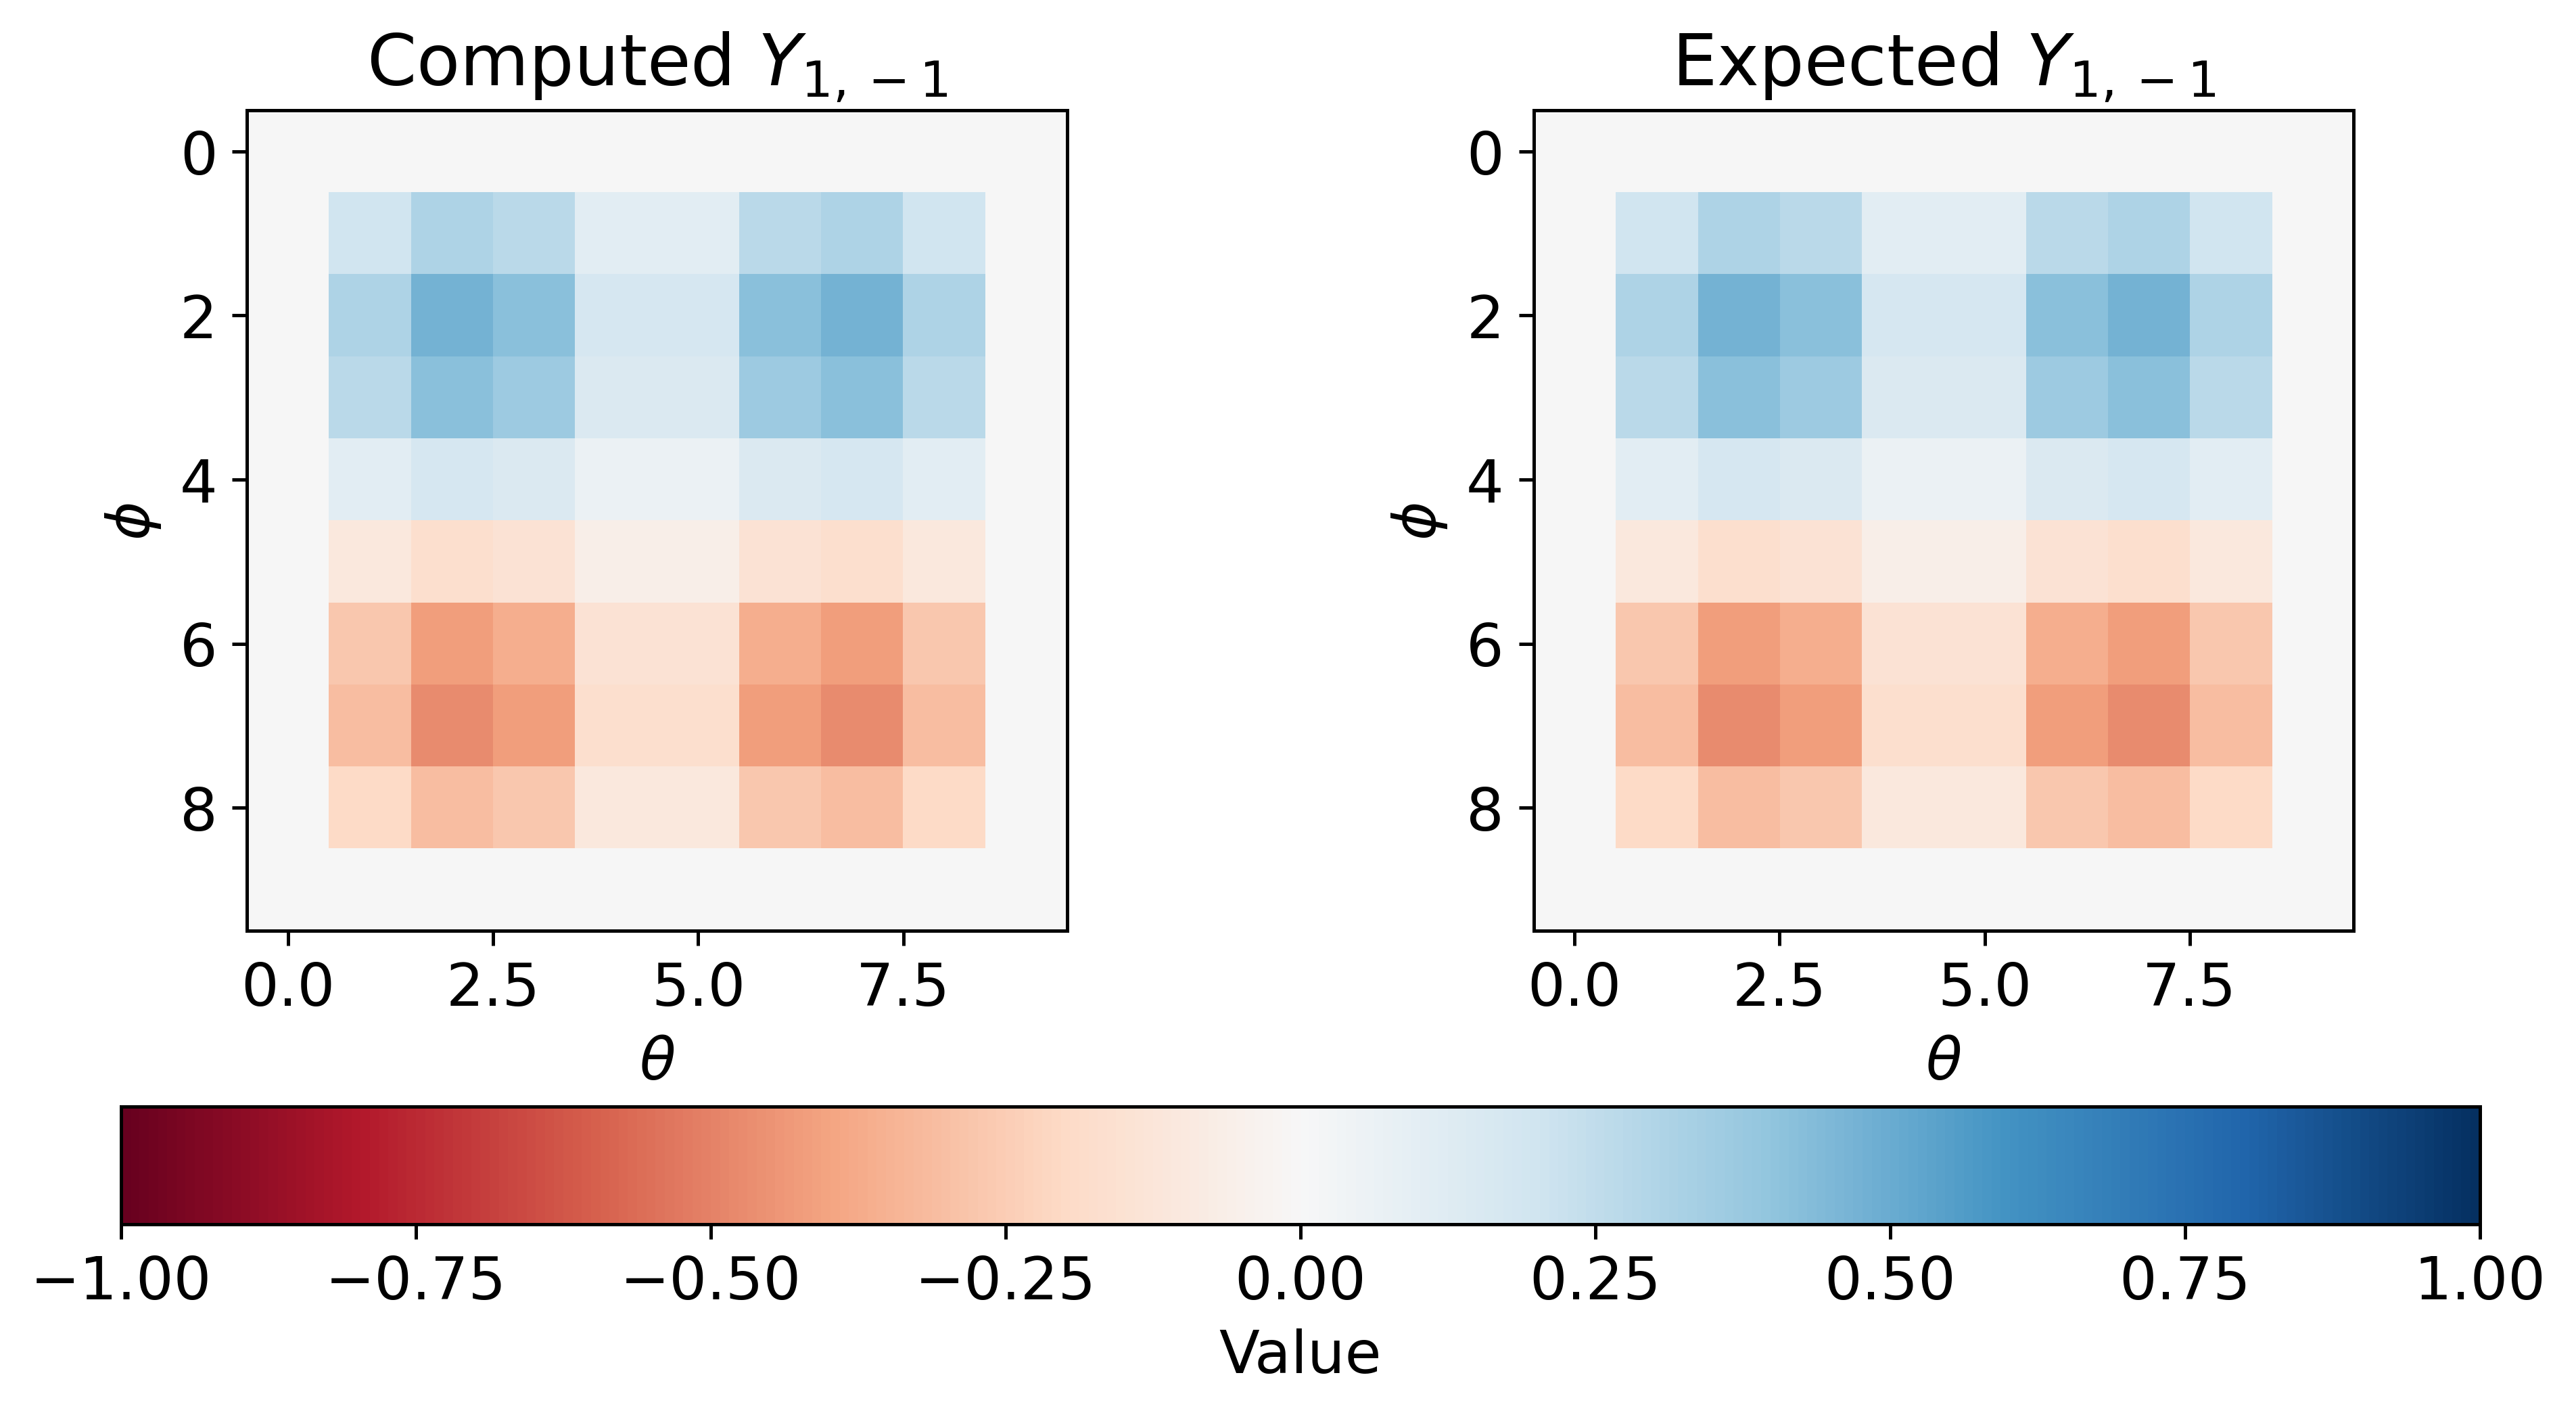

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

axs[0].imshow(RectangularSignal.from_function(spherical_harmonic(1, -1), 10, 10, True).grid_values.T, cmap='RdBu', vmin=-1, vmax=1)
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\phi$")
axs[0].set_title(r"Computed $Y_{1,-1}$")

axs[1].imshow(RectangularSignal.from_function(expected_Y[(1, -1)], 10, 10, True).grid_values.T, cmap='RdBu', vmin=-1, vmax=1)
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$\phi$")
axs[1].set_title(r"Expected $Y_{1,-1}$")
fig.colorbar(mappable=axs[0].images[0], ax=axs, orientation='horizontal', label='Value')
plt.show()

$Y_{lm}(\theta, \phi) = \sum_{u,v} ({y^{lm}_{uv}})^* \exp{i (u \theta + v \phi)}$


In [7]:
def fourier_function(u: int, v: int) -> Callable[[float, float], float]:
    """Fourier function on the sphere."""
    def fourier(theta: float, phi: float) -> float:        
        return jnp.exp(1j * (u * theta + v * phi)) / (2 * jnp.pi)
    return fourier


@functools.lru_cache(maxsize=None)
def create_spherical_harmonic_signal(l: int, m: int, **grid_kwargs):
    """Creates a signal for Y^{l,m}."""
    return RectangularSignal.from_function(spherical_harmonic(l, m), **grid_kwargs)


@functools.lru_cache(maxsize=None)
def create_fourier_signal(u: int, v: int, **grid_kwargs):
    """Creates a signal for Fourier function defined by {u, v}."""
    return RectangularSignal.from_function(fourier_function(u, v), **grid_kwargs)


@functools.lru_cache(maxsize=None)
def compute_y(l: int, m: int, u: int, v: int, **grid_kwargs):
    """Computes y^{l,m}_{u, v}."""
    Y_signal = create_spherical_harmonic_signal(l, m, **grid_kwargs, wrap_theta=True)
    F_signal = create_fourier_signal(u, v, **grid_kwargs, wrap_theta=False)
    return (Y_signal * F_signal).integrate()


def to_u_index(u: int, lmax: int) -> int:
    """Returns the index of u in the grid."""
    return u + lmax

def to_v_index(v: int, lmax: int) -> int:
    """Returns the index of v in the grid."""
    return v + lmax

def compute_y_grid(lmax: int, **grid_kwargs):
    """Computes the grid of y^{l,m}_{u, v}."""
    lm_indices = jnp.arange((lmax + 1) ** 2)
    us = jnp.arange(-lmax, lmax + 1)
    vs = jnp.arange(-lmax, lmax + 1)
    mesh = jnp.meshgrid(lm_indices, us, vs, indexing='ij')
    
    y_grid = np.zeros(((lmax + 1) ** 2, 2 * lmax + 1, 2 * lmax + 1), dtype=jnp.complex64)
    for lm_index, u, v in zip(*[m.ravel() for m in mesh]):
        l, m = from_lm_index(lm_index)
        u_index = to_u_index(u, lmax)
        v_index = to_v_index(v, lmax)
        l, m, u, v = int(l), int(m), int(u), int(v)
        y_grid[lm_index, u_index, v_index] = compute_y(l, m, u, v, **grid_kwargs)

    assert y_grid.shape == ((lmax + 1) ** 2, 2 * lmax + 1, 2 * lmax + 1)
    return y_grid



In [8]:
grid_kwargs = dict(res_theta=100, res_phi=100)
lmax = 2

In [10]:
u, v = 1, 0
F_signal = RectangularSignal.from_function(fourier_function(u, v), **grid_kwargs, wrap_theta=False)
Y_signal = RectangularSignal.from_function(lambda theta, phi: 1, **grid_kwargs, wrap_theta=True)
YF_signal = Y_signal * F_signal
YF_signal.integrate()

Array(2.8522396e-07-2.8522396e-07j, dtype=complex64)

In [11]:
failed = []
for u in range(-lmax, lmax + 1):
    for v in range(-lmax, lmax + 1):
        F_signal = RectangularSignal.from_function(fourier_function(u, v), **grid_kwargs, wrap_theta=False)
        F_signal_conj = RectangularSignal.from_function(lambda theta, phi: jnp.conj(fourier_function(u, v)(theta, phi)), **grid_kwargs, wrap_theta=False)
        if not jnp.allclose((F_signal * F_signal_conj).integrate(), 1):
            print(f"Failed: u={u}, v={v}, integral={(F_signal_conj * F_signal).integrate()}")
            failed.append((u, v))
if not failed:
    print("All tests passed")

All tests passed


In [22]:
l, m = 3, 2
lmax = 4

assert jnp.abs(m) <= l
y_grid = compute_y_grid(lmax, **grid_kwargs)

y_lm = y_grid[to_lm_index(l, m)]

(25, 9, 9)


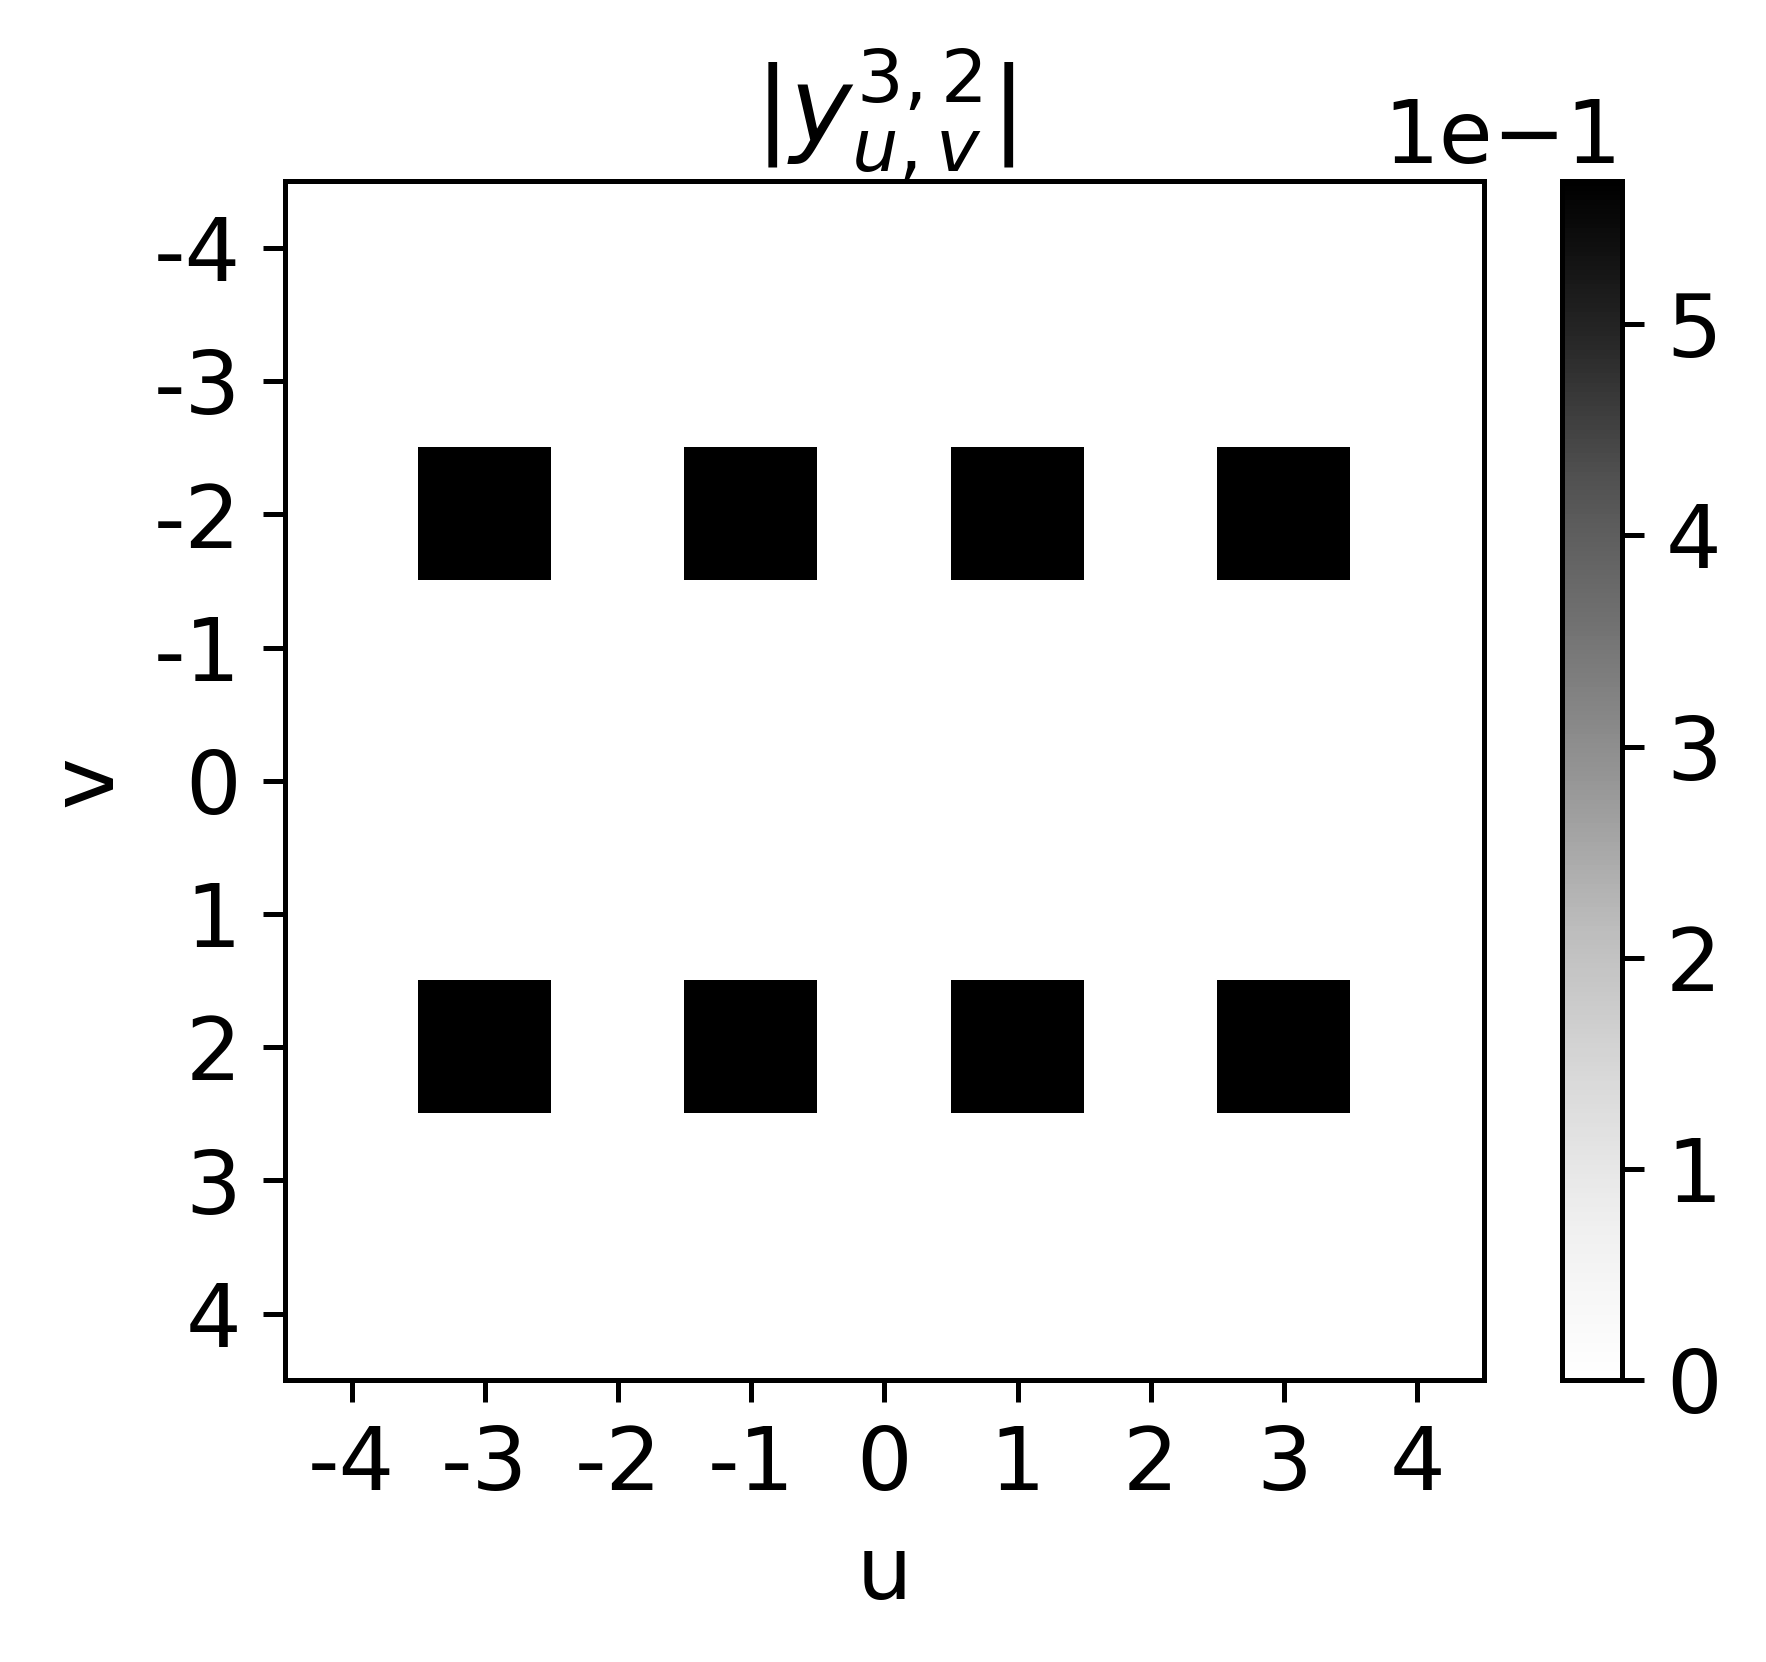

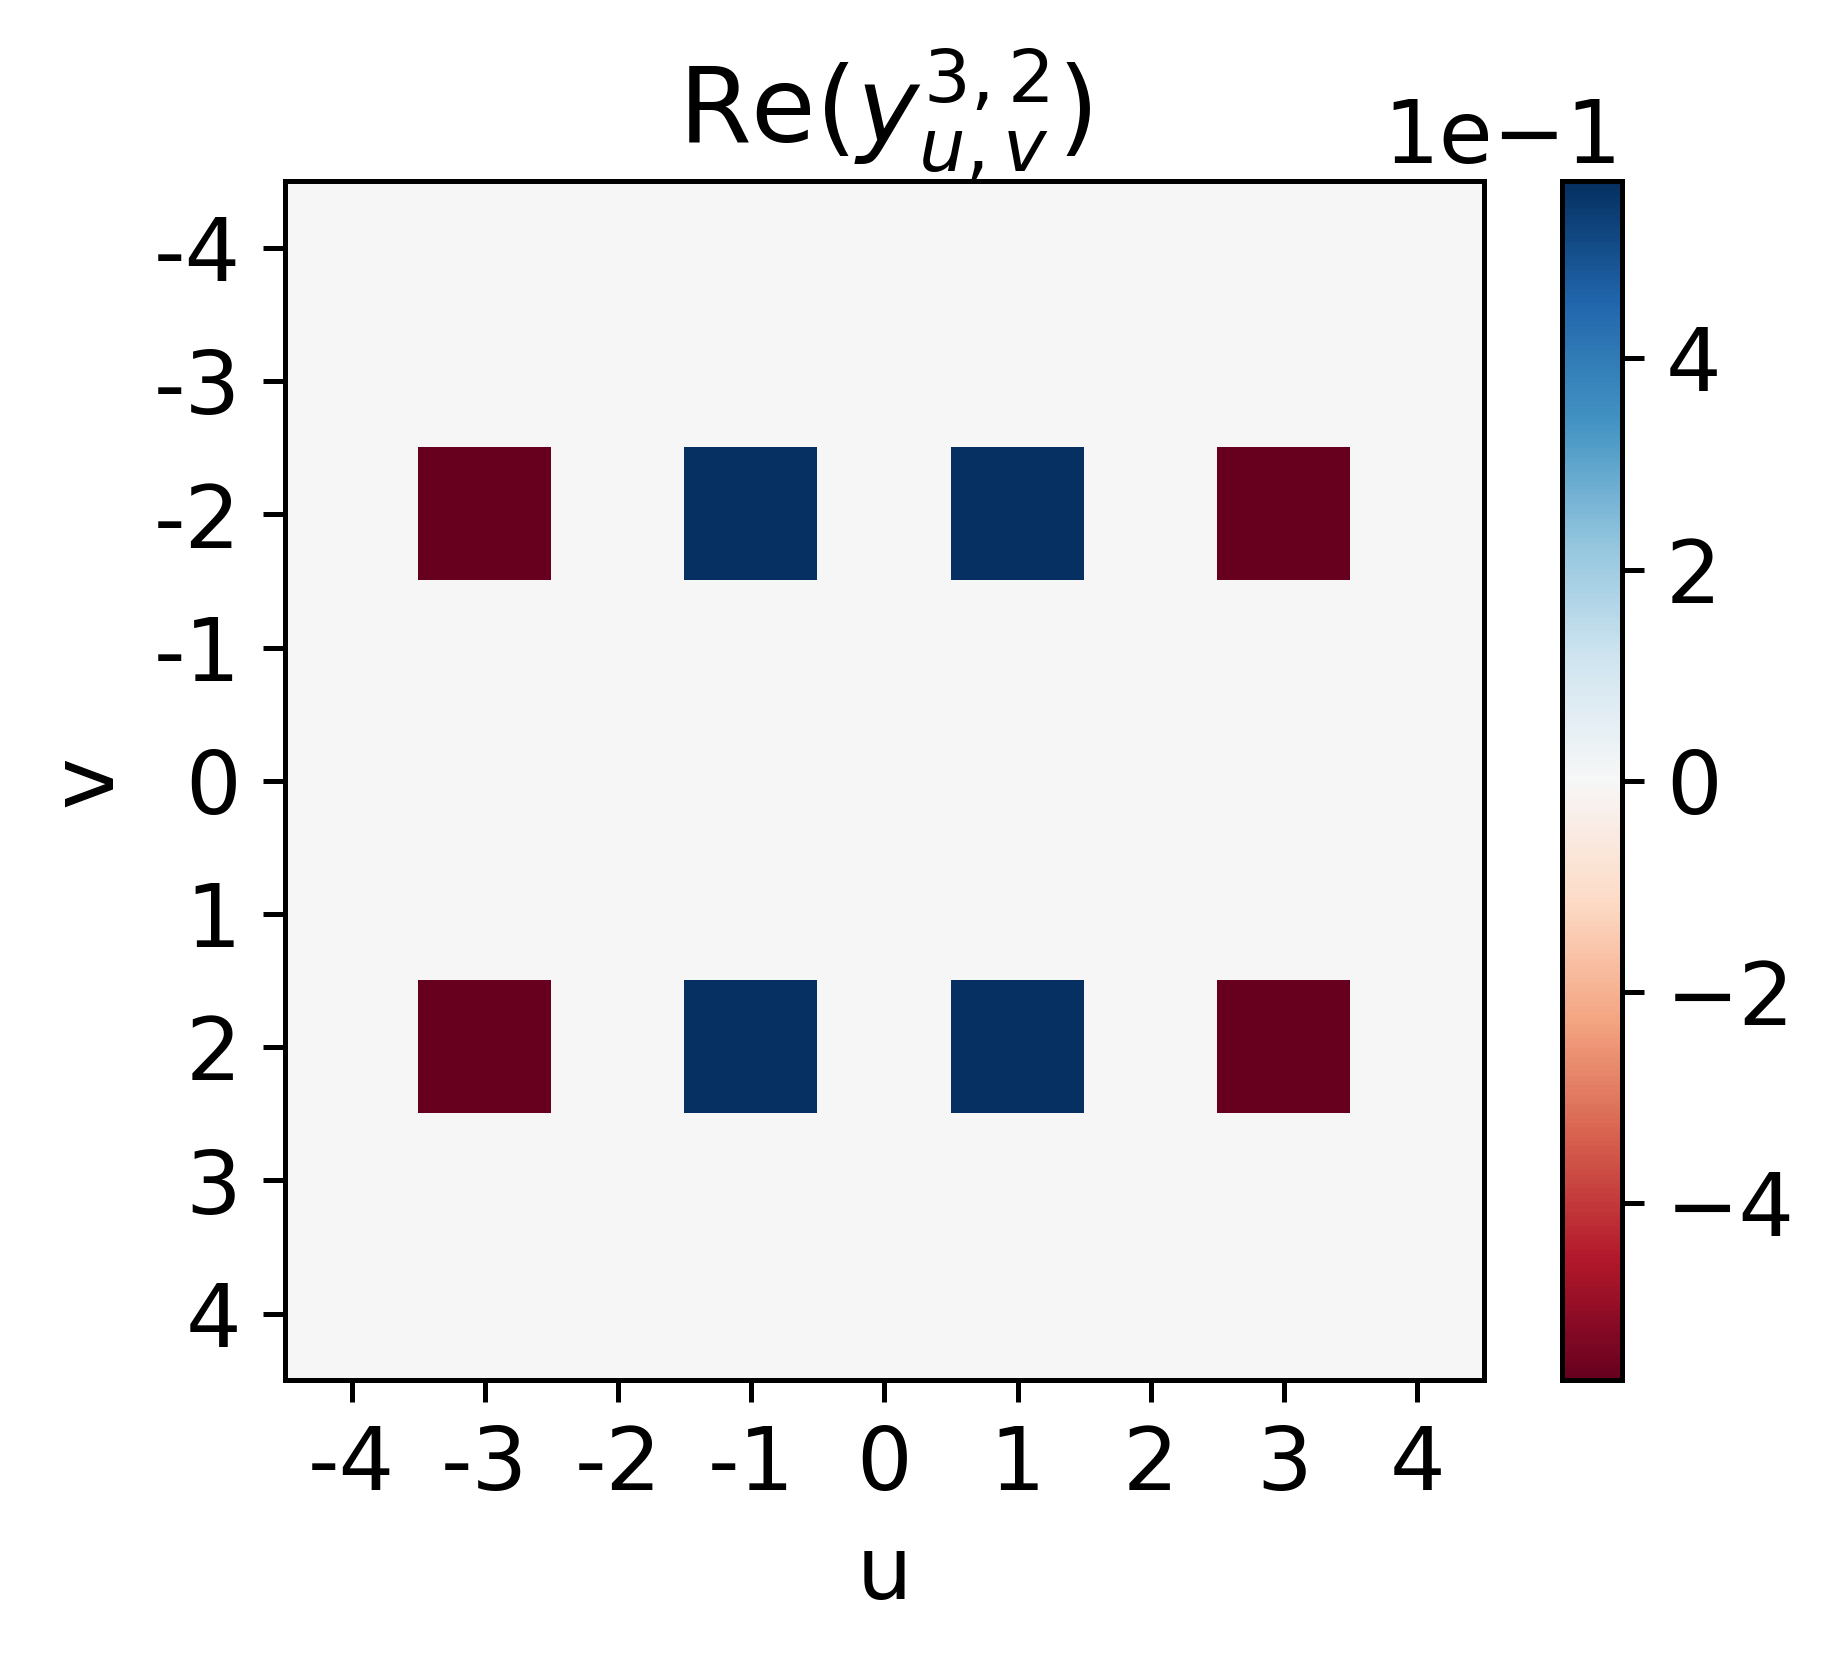

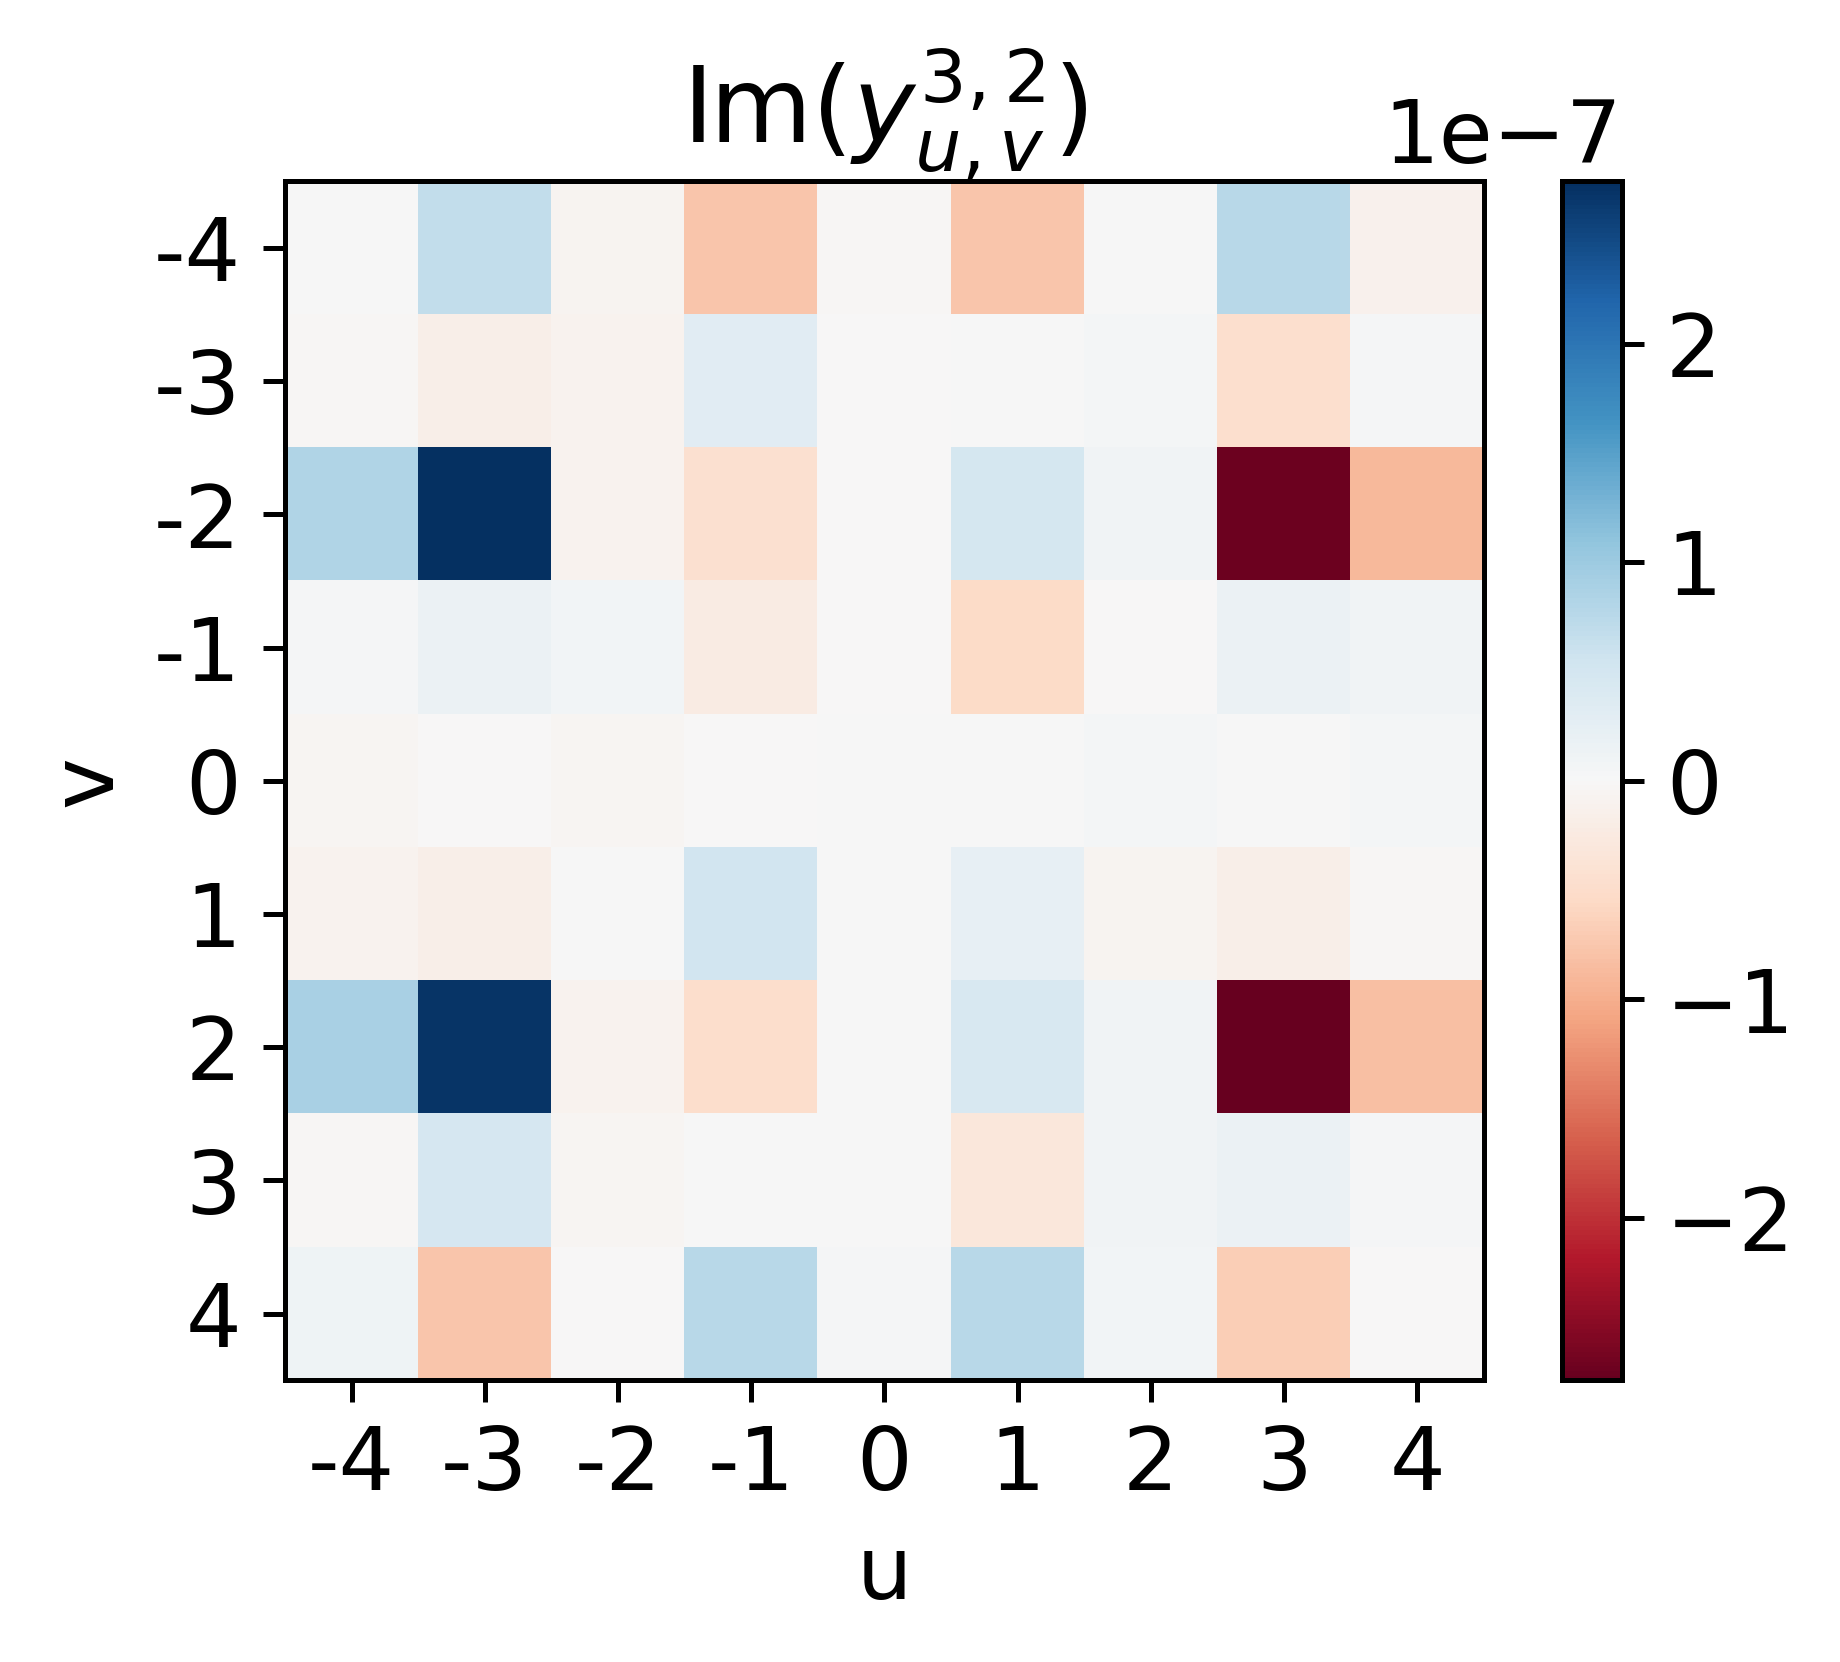

In [24]:
plt.imshow(jnp.abs(y_lm).T, cmap="Grays", vmin=0)
plt.title("$|y_{{u, v}}^{{%d,%d}}|$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=-jnp.real(y_lm).max(), vcenter=0, vmax=jnp.real(y_lm).max())
plt.imshow(jnp.real(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Re}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=-jnp.imag(y_lm).max(), vcenter=0, vmax=jnp.imag(y_lm).max())
plt.imshow(jnp.imag(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Im}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

In [32]:
# Transform SH coefficients to 2D Fourier coefficients
x1_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(1)).array
x1_uv = jnp.einsum("a, auv->uv", x1_lm, y_grid)
assert x1_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

x2_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(2)).array
x2_uv = jnp.einsum("a, auv->uv", x2_lm, y_grid)
assert x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

In [38]:
z_grid = y_grid.transpose((0, 2, 1)).conj()
print(z_grid.shape)

(25, 9, 9)


In [41]:
# Check that we can convert back to SH coefficients
x1_lm_reconstructed = jnp.einsum("uv,auv->a", x1_uv, y_grid.conj())
x1_lm_reconstructed, x1_lm=
# assert jnp.allclose(x1_lm, x1_lm_reconstructed)

(Array([ 0.83120984-1.04360964e-14j, -1.8700825 +6.01755890e-09j,
         8.692972  -6.99440506e-15j,  1.376153  -1.08337144e-08j,
         0.84318256+2.06146744e-08j,  0.40428224-2.94787683e-09j,
        -2.906197  -6.66133815e-15j, -0.03472763-1.28829480e-09j,
        -1.4670362 -4.07036627e-09j, -0.7698404 +3.14275894e-08j,
        -2.692414  -3.24068274e-08j, -0.03078558-5.38771783e-09j,
        10.12367   -9.54791801e-15j, -0.13436924-5.99164718e-09j,
        -9.575475  +5.13410114e-09j, -3.520239  +2.36780373e-10j,
         1.9517872 +6.70552254e-08j, -4.455887  -2.93056601e-09j,
        -2.605403  -2.39464857e-08j, -1.2906563 +3.52638674e-09j,
         2.2460666 +1.42108547e-14j, -0.699774  -4.60160887e-09j,
        -3.5786977 -7.16254744e-09j,  5.313658  -7.39261719e-09j,
        -4.230806  -2.14204192e-08j], dtype=complex64),
 Array([ 0.59333676, -0.82349354,  1.1586576 ,  0.61708856,  0.5213631 ,
         0.2781005 , -1.2627544 ,  0.05730288, -0.49172685, -0.35850936,
      

In [28]:
# 2D FFT
x1_fft = jnp.fft.fft2(x1_uv)
x2_fft = jnp.fft.fft2(x2_uv)
assert x1_fft.shape == (2 * lmax + 1, 2 * lmax + 1)
assert x2_fft.shape == (2 * lmax + 1, 2 * lmax + 1)

# Product in Fourier space
x1_x2_fft = x1_fft * x2_fft
assert x1_x2_fft.shape == (2 * lmax + 1, 2 * lmax + 1)

# Inverse 2D FFT
x1_x2_uv = jnp.fft.ifft2(x1_x2_fft)
assert x1_x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

# Convert back to spherical harmonics
x1_x2_lm = jnp.einsum("uv, auv->a", x1_x2_uv, jnp.conj(y_grid))
assert x1_x2_lm.shape == ((lmax + 1) ** 2,)

# Hmm, the result is not real, but it should be

In [29]:
x1_lm, x2_lm, x1_x2_lm

(Array([ 0.59333676, -0.82349354,  1.1586576 ,  0.61708856,  0.5213631 ,
         0.2781005 , -1.2627544 ,  0.05730288, -0.49172685, -0.35850936,
        -1.0447503 ,  0.1234699 ,  1.1976635 , -0.14236492, -3.7156198 ,
        -1.6393571 ,  0.92326057, -1.8844254 , -0.96750796, -0.63999134,
         0.8939773 , -0.32139128, -1.1945072 ,  2.2471828 , -2.0013103 ],      dtype=float32),
 Array([-2.0156333 ,  1.2593485 ,  0.2872979 , -1.1564215 ,  1.5720803 ,
        -0.64078444, -0.26815253, -0.4039662 ,  0.4879386 , -0.4484471 ,
        -0.64205116,  2.4383266 , -0.5523814 , -0.40515277,  0.30497968,
         0.69095296,  0.00310057, -0.5536178 ,  3.0834992 , -0.18839876,
        -0.24827515, -2.0751693 , -0.7766628 , -0.2847536 ,  2.230129  ],      dtype=float32),
 Array([ -8.573175  -9.994613j  ,   2.275036  +7.603299j  ,
        -17.956024 -28.087334j  , -13.040658 +10.75723j   ,
         17.51435   -4.879219j  , -25.924227  -7.535429j  ,
        -21.132627 -16.075891j  , -14.534771 +

In [30]:
x1_x2_lm

Array([ -8.573175  -9.994613j  ,   2.275036  +7.603299j  ,
       -17.956024 -28.087334j  , -13.040658 +10.75723j   ,
        17.51435   -4.879219j  , -25.924227  -7.535429j  ,
       -21.132627 -16.075891j  , -14.534771 +17.2514j    ,
       -12.395637  +3.3405387j ,  20.895443  +2.9884312j ,
        -1.9022946 -2.541226j  , -20.002792 -10.916849j  ,
        -1.8644893+11.603484j  , -32.771088 +11.427243j  ,
        -3.033271  +6.972446j  , -10.458093  +1.6895403j ,
         9.606606  +1.9491742j ,  14.36073   +3.272675j  ,
         3.7357738-13.112579j  ,   1.1221873 -0.8546169j ,
        22.378008 +12.889113j  ,  -5.533566  +0.49029437j,
       -13.56861  +10.281063j  ,  -4.173063  +9.459166j  ,
       -17.087873  -9.606594j  ], dtype=complex64)

In [31]:
product = e3nn.to_s2grid(e3nn.IrrepsArray(e3nn.s2_irreps(lmax), x1_x2_lm), **s2grid_kwargs)
go.Figure([go.Surface(product.plotly_surface())])


NameError: name 's2grid_kwargs' is not defined